# dev_HistogramMutualInformation
This notebook will be dedicated to developing the code to compute the mutual information as a function of height using the vcfs-per-event netcdf datasets

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '..')

from atl09_cloudnet.definitions import indices

In [2]:
import xarray as xr
import numpy as np
import os
from xhistogram.xarray import histogram as xhist

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import ScalarMappable
import cmcrameri.cm as cm

In [24]:
CMAP_MI = cm.navia

In [25]:
def iterate_index_func(index_func):
    """Generator that stops when InvalidIndexError is raised"""
    i = 0
    while True:
        try:
            yield index_func(i)
            i += 1
        except indices.InvalidIndexError:
            return  # Stops the generator

In [26]:
def parameterisation_to_netcdf_fname(param: indices.Parametrisation, site: str) -> str:
    R_km = param.distance_km
    tau_s = int( param.tau.total_seconds() )
    return f"vcfs-per-event_{site}_{R_km}km_{tau_s:06}s.nc"

In [27]:
sites = ("ny-alesund", "hyytiala", "juelich", "munich")
vcf_per_event_dir = "/work/scratch-nopw2/eeasm/vcfs_per_event"

In [28]:
SITE = "hyytiala"

In [9]:
def has_all_files(site):
    return all((
        os.path.isfile(
            os.path.join(
                vcf_per_event_dir, 
                fname
            )
        )
        for params in iterate_index_func(indices.R_150km_tau_172800s)
        if (fname:=parameterisation_to_netcdf_fname(params, site)) is not None
    ))

site_has_all_files = {site: has_all_files(site) for site in sites}
site_has_all_files

{'ny-alesund': True, 'hyytiala': True, 'juelich': True, 'munich': False}

# Individual (R, tau)

In [50]:
%%time
index = 200


fpath = os.path.join(
    vcf_per_event_dir,
    parameterisation_to_netcdf_fname(
        indices.R_150km_tau_172800s(index),
        SITE
    )
)

vcfs_per_event = xr.load_dataset(fpath)
vcfs_per_event

CPU times: user 5.48 ms, sys: 1.19 ms, total: 6.67 ms
Wall time: 6.8 ms


<xarray.Dataset> Size: 426kB
Dimensions:              (collocation_event: 521, height: 50)
Coordinates:
  * height               (height) int64 400B 0 240 480 720 ... 11280 11520 11760
Dimensions without coordinates: collocation_event
Data variables:
    vcf_atl09            (collocation_event, height) float64 208kB 0.0 ... 0.0
    vcf_cloudnet         (collocation_event, height) float64 208kB 0.0 ... 0.0
    n_profiles_atl09     (collocation_event) int64 4kB 1519 1848 ... 1547 822
    n_profiles_cloudnet  (collocation_event) int64 4kB 215 215 213 ... 180 300

In [54]:
vcfs_per_event.expand_dims(
    dim = {
        "R_km": [25],
        "tau_s": [4000]
    }
)

<xarray.Dataset> Size: 426kB
Dimensions:              (R_km: 1, tau_s: 1, collocation_event: 521, height: 50)
Coordinates:
  * R_km                 (R_km) int64 8B 25
  * tau_s                (tau_s) int64 8B 4000
  * height               (height) int64 400B 0 240 480 720 ... 11280 11520 11760
Dimensions without coordinates: collocation_event
Data variables:
    vcf_atl09            (R_km, tau_s, collocation_event, height) float64 208kB ...
    vcf_cloudnet         (R_km, tau_s, collocation_event, height) float64 208kB ...
    n_profiles_atl09     (R_km, tau_s, collocation_event) int64 4kB 1519 ... 822
    n_profiles_cloudnet  (R_km, tau_s, collocation_event) int64 4kB 215 ... 300

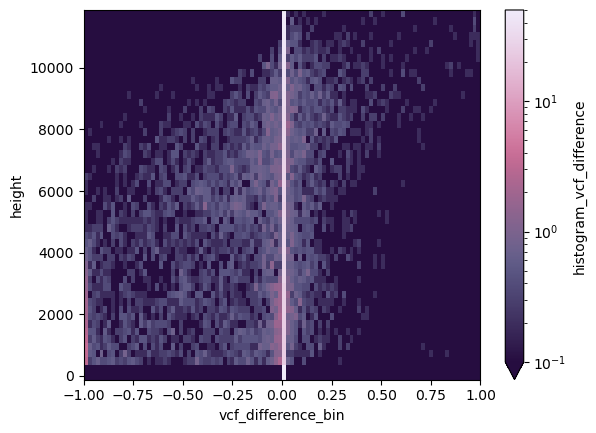

In [27]:
# absolute difference
xhist(
    (vcfs_per_event.vcf_atl09 - vcfs_per_event.vcf_cloudnet).rename("vcf_difference"),
    bins=100,
    dim=["collocation_event"],
    density=True
).plot(
    y="height", 
    norm=LogNorm(vmin=1e-1, clip=True),
    cmap = cm.acton,
    #xscale="log"
)
plt.show()

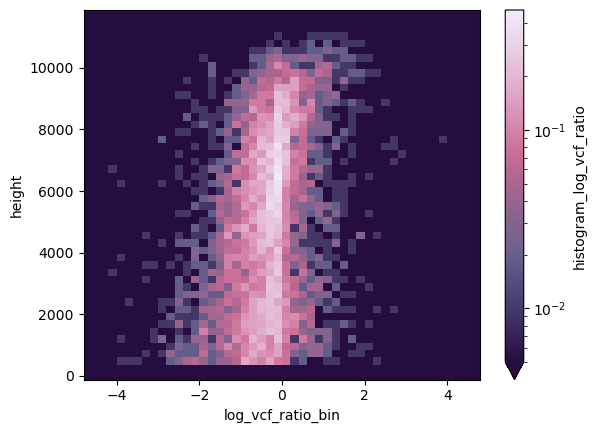

In [49]:
# log ratio
log_ratio_limit = 5
log_ratio_da = xhist(
    (
        (
            np.log10(vcfs_per_event.vcf_atl09) - 
            np.log10(vcfs_per_event.vcf_cloudnet)
        )
            .fillna(-log_ratio_limit)
            .clip(-log_ratio_limit,log_ratio_limit)
    ).rename("log_vcf_ratio"),
    bins=50,
    dim=["collocation_event"],
    density=True
)
log_ratio_da.isel(log_vcf_ratio_bin=slice(1,-1)).plot(
    y="height", 
    norm=LogNorm(vmin=5e-3, clip=True),
    cmap = cm.acton,
    #xscale="log"
)
plt.show()

# Mutual information calculation (Individual (R, tau))

In [81]:
BINS_vcf = 100

def counts_from_raw_vcfs_per_profile(ds: xr.Dataset) -> xr.DataArray:
    hist_da = xhist(
        ds.vcf_atl09, 
        ds.vcf_cloudnet,
        bins=[BINS_vcf, BINS_vcf], 
        dim=["collocation_event"],
        #density=True
    )
    return hist_da

def fill_non_finite(da: xr.DataArray, fill_val = 0) -> xr.DataArray:
    return xr.where(
        np.isfinite(da),
        da,
        fill_val
    ).copy()

def mutual_information_with_height(counts: xr.DataArray, dim: list[str] = ["vcf_atl09_bin", "vcf_cloudnet_bin"]) -> xr.DataArray:
    probability = counts / counts.sum(dim=dim)
    log_term = fill_non_finite(
        np.log2(probability) 
        - np.log2(probability.sum(dim=dim[0])) 
        - np.log2(probability.sum(dim=dim[1]))
    )
    return (
        (probability * log_term)
            .sum(dim=dim)
            .rename("mutual_information")
    )

In [ ]:
%%time
MI = mutual_information_with_height(
    counts = counts_from_raw_vcfs_per_profile(vcfs_per_event)
)
MI

In [ ]:
MI.plot(y="height")

In [53]:
MI.mean()

<xarray.DataArray 'mutual_information' ()> Size: 8B
array(1.2019643)

# All MI values per site

In [56]:
%%time
MI_values_by_R_tau = dict() 

for n, params in enumerate(iterate_index_func(indices.R_150km_tau_172800s)):
    fpath = os.path.join(
        vcf_per_event_dir,
        parameterisation_to_netcdf_fname(params, SITE)
    )
    ds = xr.load_dataset(fpath)
    MI = float(
        mutual_information_with_height(
            counts = counts_from_raw_vcfs_per_profile(ds)
        ).mean(dim="height")
    )
    R_km = params.distance_km
    tau_s = int( params.tau.total_seconds() )
    if R_km not in MI_values_by_R_tau:
        MI_values_by_R_tau[R_km] = dict()
    MI_values_by_R_tau[R_km][tau_s] = MI

/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero enco

CPU times: user 8.88 s, sys: 3.62 s, total: 12.5 s
Wall time: 14 s


/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero enco

In [63]:
%%time
coords_R_km = sorted([R for R in MI_values_by_R_tau.keys()])
coords_tau_s = sorted([tau for tau in MI_values_by_R_tau[coords_R_km[-1]].keys() ])

nR, nTau = len(coords_R_km), len(coords_tau_s)

MI_field = np.zeros((nR, nTau))

for iR, R in enumerate(coords_R_km):
    for iTau, Tau in enumerate(coords_tau_s):
        MI_field[iR, iTau] = MI_values_by_R_tau[R][Tau]

da_MI = xr.DataArray(
    data = MI_field,
    coords = {
        "R_km": (("R_km",), coords_R_km),
        "tau_s": (("tau_s",), coords_tau_s)
    },
    dims = ("R_km", "tau_s",),
    name="mutual_information"
)
da_MI

CPU times: user 0 ns, sys: 822 μs, total: 822 μs
Wall time: 827 μs


<xarray.DataArray 'mutual_information' (R_km: 17, tau_s: 26)> Size: 4kB
array([[0.35404264, 0.41272369, 0.43822856, 0.46817633, 0.48422643,
        0.50375701, 0.53854169, 0.55551777, 0.58228327, 0.59271262,
        0.60670009, 0.62063717, 0.65039089, 0.68105571, 0.69084267,
        0.68899601, 0.69375504, 0.68771794, 0.71656669, 0.71472663,
        0.71602307, 0.72723662, 0.7134681 , 0.69820658, 0.69142457,
        0.7016424 ],
       [0.39255589, 0.46024435, 0.52133724, 0.54537117, 0.57136377,
        0.59222609, 0.63699993, 0.66175463, 0.69963483, 0.71812475,
        0.73906032, 0.76410143, 0.80229114, 0.84157167, 0.84623974,
        0.84992126, 0.84837364, 0.84237626, 0.86569203, 0.8592787 ,
        0.86180911, 0.85299569, 0.83930275, 0.82890133, 0.80962708,
        0.82808178],
       [0.48056363, 0.55375415, 0.6333468 , 0.67429439, 0.71431652,
        0.74258491, 0.79957468, 0.84413067, 0.88678053, 0.91657173,
        0.94372433, 0.98420789, 1.03845374, 1.08673115, 1.09843787,
        1.11711612, 1.12456994, 1.11121027, 1.12897249, 1.11968227,
        1.11841482, 1.099325  , 1.08857818, 1.07227695, 1.05558015,
        1.05384677],
       [0.50068339, 0.58966247, 0.67039724, 0.7138266 , 0.75855529,
        0.79272102, 0.85939374, 0.90937762, 0.95557992, 0.98545747,
...
        1.43085855, 1.39989761, 1.37068569, 1.34440985, 1.31581918,
        1.29517477],
       [0.43272789, 0.54766004, 0.62643418, 0.68545715, 0.73662103,
        0.77829336, 0.86761692, 0.93286452, 0.98411535, 1.03611717,
        1.10801163, 1.17651848, 1.22201417, 1.29905553, 1.34062805,
        1.36764308, 1.39848821, 1.41007604, 1.41368998, 1.41436623,
        1.40375702, 1.38008395, 1.3492594 , 1.32115215, 1.29035099,
        1.27282352],
       [0.3979053 , 0.5137064 , 0.59086581, 0.64687942, 0.69363716,
        0.73724537, 0.82878139, 0.89402129, 0.94649553, 0.99246938,
        1.06104471, 1.12183336, 1.17094372, 1.24556722, 1.29029215,
        1.32267534, 1.35355707, 1.37184993, 1.37819014, 1.3764902 ,
        1.37263541, 1.34954734, 1.31798203, 1.29063926, 1.26035965,
        1.23887743],
       [0.36967394, 0.4811355 , 0.55861758, 0.61196346, 0.65643926,
        0.69533837, 0.78025217, 0.84673998, 0.90079258, 0.94475079,
        1.01493303, 1.07045977, 1.11948229, 1.18904849, 1.23321472,
        1.26237035, 1.3003719 , 1.32031005, 1.32952231, 1.3311192 ,
        1.33105103, 1.30658417, 1.28215579, 1.25482285, 1.22426437,
        1.20168483]])
Coordinates:
  * R_km     (R_km) float64 136B 5.0 10.0 15.0 20.0 ... 90.0 100.0 125.0 150.0
  * tau_s    (tau_s) int64 208B 300 600 900 1200 ... 108000 129600 151200 172800

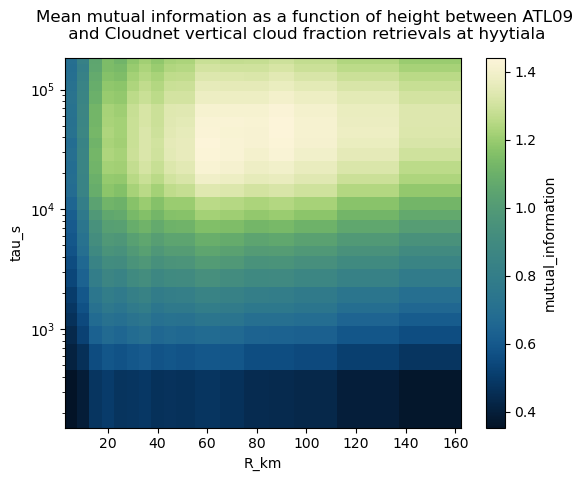

In [74]:
da_MI.plot(x="R_km", y="tau_s", cmap=cm.navia)
plt.gca().set_yscale("log")
plt.gcf().suptitle(f"Mean mutual information as a function of height between ATL09\n and Cloudnet vertical cloud fraction retrievals at {SITE}")
#plt.gca().set_xscale("log")
plt.show()

# lets do it for all sites!

In [34]:
def MI_values_by_R_tau_for_site(site: str):
    MI_values_by_R_tau = dict()
    for n, params in enumerate(iterate_index_func(indices.R_150km_tau_172800s)):
        fpath = os.path.join(
            vcf_per_event_dir,
            parameterisation_to_netcdf_fname(params, site)
        )
        ds = xr.load_dataset(fpath)
        MI = float(
            mutual_information_with_height(
                counts = counts_from_raw_vcfs_per_profile(ds)
            ).mean(dim="height")
        )
        R_km = params.distance_km
        tau_s = int( params.tau.total_seconds() )
        if R_km not in MI_values_by_R_tau:
            MI_values_by_R_tau[R_km] = dict()
        MI_values_by_R_tau[R_km][tau_s] = MI
    return MI_values_by_R_tau

def da_MI_from_MI_values_by_R_tau(MI_values_by_R_tau) -> xr.Dataset:
    coords_R_km = sorted([R for R in MI_values_by_R_tau.keys()])
    coords_tau_s = sorted([tau for tau in MI_values_by_R_tau[coords_R_km[-1]].keys() ])
    
    nR, nTau = len(coords_R_km), len(coords_tau_s)
    
    MI_field = np.zeros((nR, nTau))
    
    for iR, R in enumerate(coords_R_km):
        for iTau, Tau in enumerate(coords_tau_s):
            MI_field[iR, iTau] = MI_values_by_R_tau[R][Tau]
    
    da_MI = xr.DataArray(
        data = MI_field,
        coords = {
            "R_km": (("R_km",), coords_R_km),
            "tau_s": (("tau_s",), coords_tau_s)
        },
        dims = ("R_km", "tau_s",),
        name="mutual_information"
    )
    return da_MI

In [64]:
def MI_cube_for_site(site: str):
    MI_das = list()
    for n, params in enumerate(iterate_index_func(indices.R_150km_tau_172800s)):
        fpath = os.path.join(
            vcf_per_event_dir,
            parameterisation_to_netcdf_fname(params, site)
        )
        ds = xr.load_dataset(fpath)
        
        R_km = params.distance_km
        tau_s = int( params.tau.total_seconds() )
        
        MI_ds = (
            mutual_information_with_height(
                counts = counts_from_raw_vcfs_per_profile(ds)
            )
                .expand_dims(
                    dim={
                        "R_km": [R_km],
                        "tau_s": [tau_s]
                    }
                )
        ).to_dataset()
        MI_ds["n_collocation_events"] = (("R","tau_s",), [[ds.collocation_event.size]])
        MI_ds["n_profiles"] = (("R","tau_s",), [[ (ds.n_profiles_atl09*ds.n_profiles_cloudnet).sum() ]])
        MI_das.append(MI_ds)
    return xr.combine_by_coords(MI_das)

In [65]:
%%time
MI_cube = MI_cube_for_site("hyytiala")
MI_cube

/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero enco

CPU times: user 9.46 s, sys: 3.19 s, total: 12.7 s
Wall time: 13.1 s


<xarray.Dataset> Size: 185kB
Dimensions:               (R_km: 17, tau_s: 26, height: 50, R: 1)
Coordinates:
  * R_km                  (R_km) float64 136B 5.0 10.0 15.0 ... 125.0 150.0
  * tau_s                 (tau_s) int64 208B 300 600 900 ... 151200 172800
  * height                (height) int64 400B 0 240 480 ... 11280 11520 11760
Dimensions without coordinates: R
Data variables:
    mutual_information    (R_km, tau_s, height) float64 177kB 0.0 ... -6.021e-16
    n_collocation_events  (R_km, R, tau_s) int64 4kB 39 39 39 39 ... 881 881 881
    n_profiles            (R_km, R, tau_s) int64 4kB 21834 43562 ... 10169434033

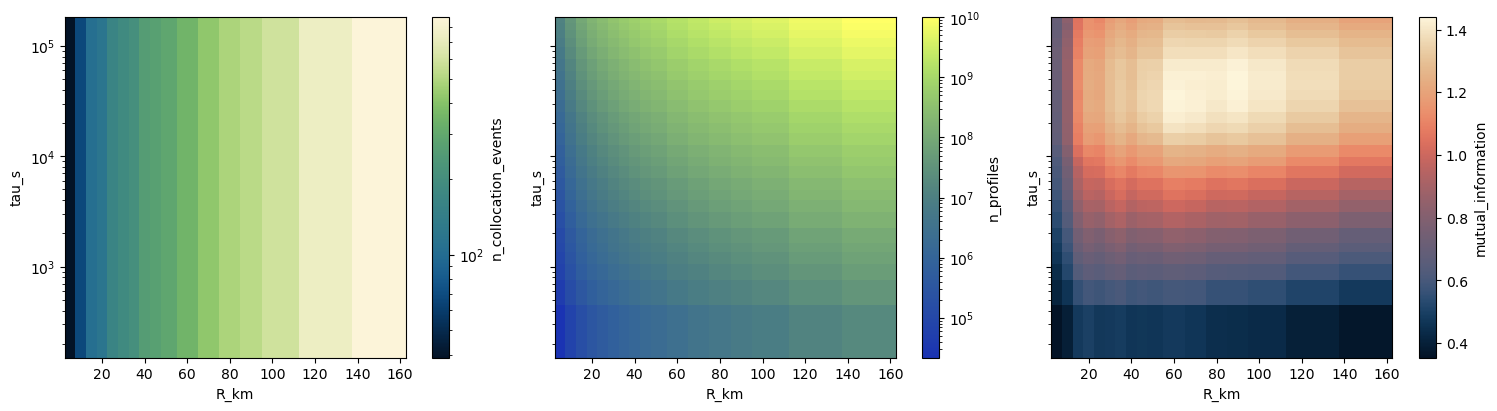

In [71]:
fig, axs = plt.subplots(1,3, layout="constrained", figsize=(15,4), sharex=True, sharey=True)

CMAP_N_coll = cm.navia
CMAP_N_prof = cm.imola

MI_cube.n_collocation_events.plot(
    x="R_km", y="tau_s", 
    ax=axs[0],
    cmap = CMAP_N_coll,
    norm=LogNorm()
)

MI_cube.n_profiles.plot(
    x="R_km", y="tau_s", 
    ax=axs[1],
    cmap = CMAP_N_prof,
    norm=LogNorm()
)

MI_cube.mutual_information.mean(dim="height").plot(
    x="R_km", y="tau_s", 
    ax=axs[2],
    cmap = CMAP_MI,
)

for ax in axs:
    ax.set_yscale("log")
    ax.set_box_aspect(1)

plt.show()

In [15]:
%%time
da_MI_by_site = {
    site: da_MI_from_MI_values_by_R_tau(
        MI_values_by_R_tau_for_site(site)
    )
    for site in sites
    if site_has_all_files[site]
}
len(da_MI_by_site)

/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero enco

CPU times: user 25.8 s, sys: 11.5 s, total: 37.2 s
Wall time: 38.7 s


/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero enco

3

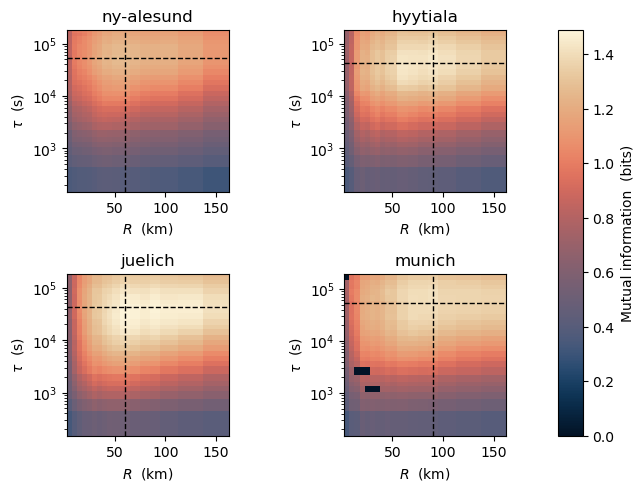

In [49]:
from matplotlib.gridspec import GridSpec

cwidth=0.1
CMAP_MI = cm.lipari

fig = plt.figure(layout="constrained")

gs = GridSpec(2,3, figure=fig, width_ratios = [1,1,cwidth], height_ratios=[1,1])

ax1 =  fig.add_subplot(gs[0, 0])
ax2 =  fig.add_subplot(gs[0, 1])
ax3 =  fig.add_subplot(gs[1, 0])
ax4 =  fig.add_subplot(gs[1, 1])
axs = (ax1, ax2, ax3, ax4)

cax = fig.add_subplot(gs[:,2])

NORM = Normalize(
    vmin=0,
    vmax = max([
        MI.max()
        for MI in da_MI_by_site.values()
    ])
)


for site, ax in zip(sites, axs):
    if site not in da_MI_by_site:
        continue
    da_MI = da_MI_by_site[site]
    da_MI.plot(
        x="R_km", y="tau_s",
        cmap=CMAP_MI,
        norm=NORM,
        ax=ax,
        add_colorbar=False
    )
    max_MI_args = {
        k: da_MI[k].isel({k:v})
        for k, v in da_MI.argmax(dim=["R_km","tau_s"]).items()
    }
    ax.axhline(max_MI_args["tau_s"], ls="--", lw=1, c="k")
    ax.axvline(max_MI_args["R_km"], ls="--", lw=1, c="k")

for site, ax in zip(sites, axs):
    ax.set_box_aspect(1)
    ax.set_yscale("log")
    ax.set_ylabel(r"$\tau$  (s)")
    ax.set_xlabel(r"$R$  (km)")
    ax.set_title(site)
    

# colorbar plotting
mappable = ScalarMappable(cmap=CMAP_MI, norm=NORM)
mappable.set_array([])
plt.colorbar(mappable, cax=cax)
cax.set_ylabel("Mutual information  (bits)")
#cax.set_yticks([0,1])
cax.yaxis.set_ticks_position("right")
#cax.yaxis.set_label_position("left")

plt.show()